# **Artificial Neural Networks and Deep Learning**

---

## Challenge 2

## 🧮 **Parameters**

In [1]:
# Set seed for reproducibility
SEED = 1

# Run locally
LOCAL_RUN = 0

# Validation set relative size
N_VAL = 0.2

# Use grayscale instead of RGB
USE_GRAYSCALE = False

# Crop patches
PATCH_SIZE = 156            # Cropped patch size (px)
PATCHES_PER_IMG = 10        # Number of patches per original image
MAX_MASK_DIST = 25          # Maximum patch center distance from mask
MIN_PATCHES_DIST = 60       # Minimum centers distance between patches

# Augmentation
N_GEOMETRIC = 2
N_COLOR = 2
MAG_GEOMETRIC = 10
MAG_COLOR = 8

# Define the batch size, which is the number of samples in each batch
BATCH_SIZE = 64

# Training configuration
LEARNING_RATE = 1e-4
EPOCHS = 500
PATIENCE = 50

# Architecture (pre-trained)
BACKBONE = "vgg19"
PRETRAINED = True
USE_CUSTOM_WEIGHTS = False
FREEZE_BACKBONE = "partial"
MASK_STRENGTH = 0.0

# Architecture (base)
NORM_TYPE = "layer"

# Architecture (common)
OPTIMIZER = "ranger"
CRITERION = "wFocal"
LABEL_SMOOTHING = 0.1

# Regularization
DROPOUT_RATE = 0.4          # Dropout probability
L1_LAMBDA = 0               # L1 penalty
L2_LAMBDA = 5e-5            # L2 penalty

## ⚙️ **Libraries Import**

In [2]:
import importlib
import subprocess
import sys
import inspect

def safe_import(path, module = None, pip_name = None):
    globals_dict = inspect.currentframe().f_back.f_globals
    pip_name = pip_name or path.split(".")[0]

    try:
        if module:
            # from path import module
            pkg = importlib.import_module(path)
            obj = getattr(pkg, module)
            globals_dict[module] = obj
        else:
            # import path
            obj = importlib.import_module(path)
            name = path.split(".")[0]
            globals_dict[name] = obj
    except ImportError:
        print(f"Installing '{pip_name}' …")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name])
        importlib.invalidate_caches()
        if module:
            # from path import module
            pkg = importlib.import_module(path)
            obj = getattr(pkg, module)
            globals_dict[module] = obj
        else:
            # import path
            obj = importlib.import_module(path)
            name = path.split(".")[0]
            globals_dict[name] = obj

In [3]:
# Import necessary libraries
import os
from IPython import get_ipython

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)

# Suppress warnings
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)
warnings.simplefilter(action = "ignore", category = Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
import tensorboard
safe_import("torch.utils.tensorboard", "SummaryWriter")
import torchvision
from torchvision.transforms import v2 as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
safe_import("torchsummary", "summary")
safe_import("torchview", "draw_graph")
import torch.nn.functional as F
safe_import("torch_optimizer", pip_name = "torch-optimizer")
safe_import("lion_pytorch", "Lion", pip_name = "lion-pytorch")

logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
os.makedirs("models", exist_ok = True)

# Non-CUDA GPU acceleration support
try:
    import torch_directml
    dml_available = True
except ImportError:
    dml_available = False

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
elif dml_available:
    device = torch_directml.device()
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
safe_import("cv2", pip_name = "opencv-python")
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
import re
import math
from datetime import datetime
from collections import Counter

# Configure plot display settings
sns.set(font_scale = 1.4)
sns.set_style("white")
plt.rc("font", size = 14)
%matplotlib inline

Installing 'torchview' …
Installing 'torch-optimizer' …
Installing 'lion-pytorch' …
PyTorch version: 2.9.0+cu126
Device: cuda


## ⏳ **Data Loading**

In [4]:
def load_images_from_folder(folder, output, use_grayscale = False):
    """
    Load and preprocess images from a specified folder.

    Args:
        folder (str): Path to the folder containing images

    Returns:
        pd.Dataframe: Dataframe of preprocessed images paths with shape (N, H, W, C)
    """
    rows = []

    files = os.listdir(folder)

    # find IDs associated to both image and mask
    pattern_img  = re.compile(r"img_(\d{4})\.png$")
    pattern_mask = re.compile(r"mask_(\d{4})\.png$")

    img_numbers  = set()
    mask_numbers = set()

    for f in files:
        if m := pattern_img.fullmatch(f):
            img_numbers.add(m.group(1))
        if m := pattern_mask.fullmatch(f):
            mask_numbers.add(m.group(1))

    common = img_numbers & mask_numbers

    # Iterate through files in the specified folder
    for n in common:
        img_file  = f"img_{n}.png"
        mask_file = f"mask_{n}.png"

        mask = cv2.imread(os.path.join(folder, mask_file), cv2.IMREAD_GRAYSCALE)

        if use_grayscale:
            img = cv2.imread(os.path.join(folder, img_file), cv2.IMREAD_GRAYSCALE)
            # Merge image and mask
            merge_img = cv2.merge((img, mask))
        else:
            img = cv2.imread(os.path.join(folder, img_file))
            # Merge image (RGB) and mask
            (b_channel, g_channel, r_channel) = cv2.split(img)
            merge_img = cv2.merge((r_channel, g_channel, b_channel, mask))

        # Convert to single-byte
        merge_img = merge_img.astype(np.uint8)

        out_path = os.path.join(output, f"{img_file}.npy")
        np.save(out_path, merge_img)

        if merge_img is not None:
            rows.append({
                "sample_index": img_file,
                "image_path": out_path
            })

    return pd.DataFrame(rows).sort_values('sample_index').reset_index(drop = True)

In [5]:
def load_from_saved(folder):
    """
    Load already preprocessed images from a specified folder.

    Args:
        folder (str): Path to the folder containing images

    Returns:
        pd.Dataframe: Dataframe of preprocessed images paths with shape (N, H, W, C)
    """
    rows = []

    for f in sorted(os.listdir(folder)):
        if f.endswith(".npy"):
            sample_index = f.replace(".npy", "")  # reverse name logic
            out_path = os.path.join(folder, f)

            rows.append({
                "sample_index": sample_index,
                "image_path": out_path
            })

    return pd.DataFrame(rows).sort_values('sample_index').reset_index(drop = True)

In [6]:
def load_image(path, normalize = True):
    image = np.load(path)

    if normalize:
        # Normalize to [0, 1] range
        image = image.astype(np.float32) / 255.0

    return image

In [7]:
def load_indexes(txt_path):
    indexes = set()
    with open(txt_path, "r") as f:
        for line in f:
            name = line.strip()
            if name:
                indexes.add(name)
    return indexes

In [8]:
%%time
if LOCAL_RUN:
    """
    Directories structure:
    /src
    > c2.ipynb
    /data
    > train_data/
    > train_labels.csv
    > test_data/
    """
    # Define data folder
    data_folder = "../data"

    # Navigate to current directory
    try:
        notebook_path = get_ipython().run_line_magic("pwd", "")
        os.chdir(notebook_path)
    except Exception as e:
        print("Error in changing directory:", e)

else:
    #  Environment detection
    def in_kaggle():
        # Kaggle kernels set this env var
        return "KAGGLE_KERNEL_RUN_TYPE" in os.environ

    def in_colab():
        try:
            import google.colab  # type: ignore
            return True
        except ImportError:
            return False

    IS_KAGGLE = in_kaggle()
    IS_COLAB = in_colab()

    assert IS_KAGGLE or IS_COLAB, "This notebook is meant to run on Kaggle or Colab."

    if IS_KAGGLE:
        """
        Directories structure (Kaggle):
        /kaggle/input/an2dlc2
        > train_data/
        > test_data/
        > train_labels.csv

        /kaggle/working
        > data_processed/
        > outputs_<timestamp>/
        """
        # Define data folder
        data_folder = "/kaggle/input/an2dlc2/"


    else:
        # Define data folder
        data_folder = "data"

        if not os.path.exists("data/train_labels.csv"):
            os.environ['KAGGLE_USERNAME'] = "giorgiamanioudaki"
            os.environ['KAGGLE_KEY'] = "1d894bf85af1afc62f1c89427d9cbf79"

            !kaggle competitions download -c an2dl2526c2v2
            !unzip -o -q an2dl2526c2v2.zip -d data

        import gdown

        gdown.download(id = "1bQznQPprgmidZH-wLGHZzrXdtqTNe7Z3", output = os.path.join(data_folder, "shrek.txt"),  quiet = False)
        gdown.download(id = "1uqq6po7PJISM2Hd9JAI5rQDZ1iv7HVhj", output = os.path.join(data_folder, "booger.txt"), quiet = False)

# Create full paths inside data_folder
paths_to_create = [
    os.path.join(data_folder, "runtime/original/train/gray"),
    os.path.join(data_folder, "runtime/original/train/rgb"),
    os.path.join(data_folder, "runtime/original/test/gray"),
    os.path.join(data_folder, "runtime/original/test/rgb"),
    os.path.join(data_folder, "runtime/crop/train"),
    os.path.join(data_folder, "runtime/crop/test"),
]
for p in paths_to_create:
    os.makedirs(p, exist_ok = True)

# Timestamp used for this run (for folders and model filenames)
RUN_TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")

if USE_GRAYSCALE:
    orig_train_dir = os.path.join(data_folder, "runtime/original/train/gray")
    orig_test_dir  = os.path.join(data_folder, "runtime/original/test/gray")
else:
    orig_train_dir = os.path.join(data_folder, "runtime/original/train/rgb")
    orig_test_dir  = os.path.join(data_folder, "runtime/original/test/rgb")

# Import training data
if len(os.listdir(orig_train_dir)) > 0:
    print("Found cached preprocessed train images → loading .npy paths...")
    X_train = load_from_saved(orig_train_dir)
else:
    print("No cached train images → processing PNGs...")
    X_train = load_images_from_folder(os.path.join(data_folder, "train_data"), orig_train_dir, use_grayscale = USE_GRAYSCALE)

# Import test data
if len(os.listdir(orig_test_dir)) > 0:
    print("Found cached preprocessed test images → loading .npy paths...")
    X_test = load_from_saved(orig_test_dir)
else:
    print("No cached test images → processing PNGs...")
    X_test = load_images_from_folder(os.path.join(data_folder, "test_data"), orig_test_dir, use_grayscale = USE_GRAYSCALE)

# Import training labels
y_train = pd.read_csv(os.path.join(data_folder, "train_labels.csv"))

assert X_train['sample_index'].equals(y_train['sample_index'])

# Import bad indexes
shrek_indexes  = load_indexes(os.path.join(data_folder, "shrek.txt"))
booger_indexes = load_indexes(os.path.join(data_folder, "booger.txt"))

print("")
print(f"Loaded {len(X_train)} training images")
print(f"Loaded {len(X_test)} test images")

 97% 907M/936M [00:17<00:00, 53.2MB/s]
100% 936M/936M [00:17<00:00, 56.0MB/s]


Downloading...
From: https://drive.google.com/uc?id=1bQznQPprgmidZH-wLGHZzrXdtqTNe7Z3
To: /content/data/shrek.txt
100%|██████████| 779/779 [00:00<00:00, 1.87MB/s]
Downloading...
From: https://drive.google.com/uc?id=1uqq6po7PJISM2Hd9JAI5rQDZ1iv7HVhj
To: /content/data/booger.txt
100%|██████████| 649/649 [00:00<00:00, 2.71MB/s]


No cached train images → processing PNGs...
No cached test images → processing PNGs...

Loaded 691 training images
Loaded 477 test images
CPU times: user 50.8 s, sys: 6.58 s, total: 57.4 s
Wall time: 2min 39s


## 🔎 **Exploration and Data Analysis**

In [9]:
def plot_images(X, num_img = 20, images_per_row = 5, index_column = 'sample_index'):
    """
    Plots all images in X with sample index above each image.

    Parameters:
        X: DataFrame with image and index columns
        images_per_row: images per row
    """
    titles = X[index_column].tolist()
    paths = X['image_path'].tolist()

    n = min(num_img, len(paths))
    paths, titles = paths[0:n], titles[0:n]
    rows = math.ceil(n / images_per_row)

    fig, axes = plt.subplots(rows, images_per_row,
                             figsize = (images_per_row * 3, rows * 3),
                             facecolor = "black")

    axes = np.array(axes).reshape(-1)

    for i, (path, title) in enumerate(zip(paths, titles)):
        image = load_image(path)

        # Convert grayscale or 2-channel to 3-channel RGB
        if image.ndim == 2:
            # grayscale → stack 3 channels
            image = np.stack([image, image, image], axis = -1)
        elif image.ndim == 3 and image.shape[-1] == 2:
            # grayscale + mask → add a third zero channel
            zero_channel = np.zeros_like(image[..., 0])
            image = np.dstack([image, zero_channel])

        ax = axes[i]
        ax.imshow(np.clip(image, 0, 1))
        ax.set_title(title, fontsize = 10, color = "white")
        ax.axis("off")

    # Hide empty cells
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.subplots_adjust(left = 0, right = 1, top = 1, bottom = 0,
                        wspace = 0.15, hspace = 0.15)

    plt.show()

In [10]:

# plot_images(X_train[X_train['sample_index'].isin(shrek_indexes)])

In [11]:
#plot_images(X_train[X_train['sample_index'].isin(booger_indexes)])

In [12]:
# Remove bad training images
bad_indexes = shrek_indexes | booger_indexes

X_train = X_train[~X_train['sample_index'].isin(bad_indexes)].reset_index(drop = True)
y_train = y_train[~y_train['sample_index'].isin(bad_indexes)].reset_index(drop = True)

print(f"Kept {len(X_train)} training images")

Kept 581 training images


In [13]:
#plot_images(X_train)

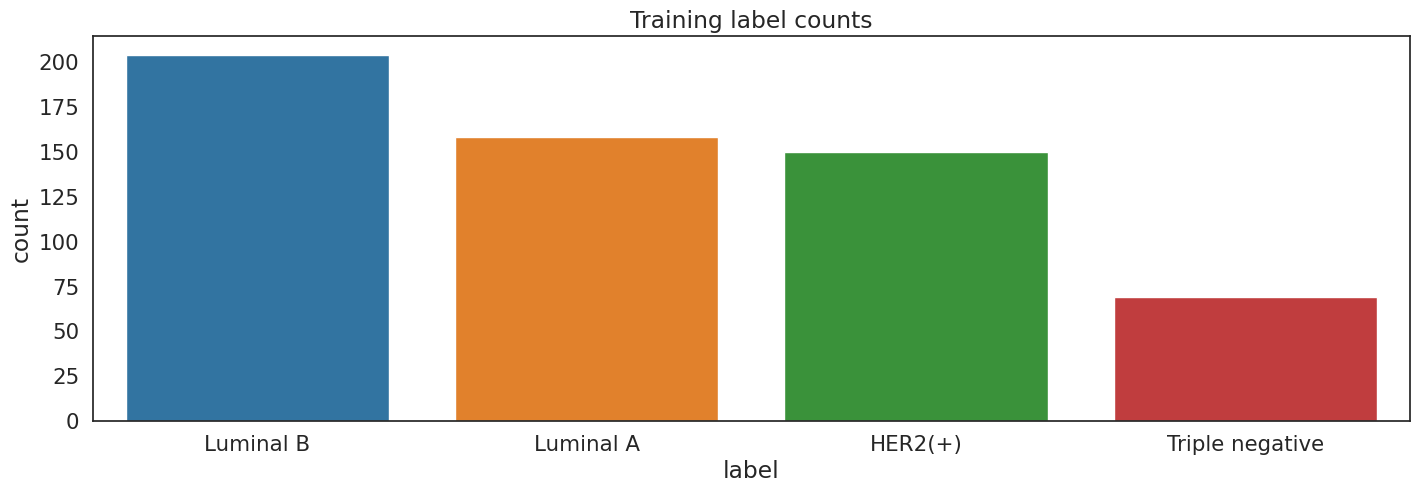

In [14]:
# Visualise the count of samples for each label
plt.figure(figsize = (17, 5))
sns.countplot(
    x = 'label',
    data = y_train,
    order = y_train['label'].value_counts().index,
    palette = "tab10"
)

# Set the title of the plot
plt.title("Training label counts")

# Display the plot
plt.show()

In [15]:
#plot_images(X_train[y_train['label'] == "Luminal A"])

In [16]:
#plot_images(X_train[y_train['label'] == "Luminal B"])

In [17]:
#plot_images(X_train[y_train['label'] == "HER2(+)"])

In [18]:
#plot_images(X_train[y_train['label'] == "Triple negative"])

## 🪲 **Data Preprocessing**

In [19]:
# Define a mapping of label names to integers
le = LabelEncoder()
le.fit(y_train['label'])

# Map strings -> integers
y_train['label'] = le.transform(y_train['label'])

# Save mapping dict (string -> int) and reverse
label_to_int = {cls: i for i, cls in enumerate(le.classes_)}
int_to_label = {i: cls for i, cls in enumerate(le.classes_)}

print(label_to_int)

{'HER2(+)': 0, 'Luminal A': 1, 'Luminal B': 2, 'Triple negative': 3}


In [20]:
# Split samples into training and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size = N_VAL,
    stratify = y_train['label'],
    random_state = SEED
)

# Print shapes of the datasets
print(f"Training Data Shape: {X_train.shape}")
print(f"Training Label Shape: {y_train.shape}")
print(f"Validation Data Shape: {X_val.shape}")
print(f"Validation Label Shape: {y_val.shape}")
print(f"Test Data Shape: {X_test.shape}")

Training Data Shape: (464, 2)
Training Label Shape: (464, 2)
Validation Data Shape: (117, 2)
Validation Label Shape: (117, 2)
Test Data Shape: (477, 2)


### Patches building

In [21]:
def crop_patches(X, output,
                 patch_size = 128,
                 patches_per_img = 10,
                 max_mask_dist = None,
                 min_patches_dist = None,
                 random_state = 42):
    """
    From a dataframe X containing images (image + mask), extract small crops
    centered on white mask pixels, generating patches_per_img crops per original image.

    Returns a dataframe with columns:
        - sample_index (same as original)
        - crop_index (unique per image)
        - crop (the cropped image path)
    """
    rng = random.Random(random_state)
    half = patch_size // 2

    if max_mask_dist is None:
        max_mask_dist = patch_size // 2

    if min_patches_dist is None:
        min_patches_dist = patch_size // 4

    results = []

    for _, row in X.iterrows():
        image = load_image(row['image_path'], normalize = False)   # shape: (H, W, C)
        sample_index = row['sample_index']

        H, W, C = image.shape

        # Extract the mask (last channel by default)
        mask = image[:, :, -1]

        # Coordinates within mask
        ys, xs = np.where(mask > 0)
        coords = list(zip(xs, ys))

        # Choose random mask pixels
        sample_coords = rng.sample(coords, min(patches_per_img * 4, len(coords)))

        scored_crops = []

        for (cx, cy) in sample_coords:
            # Random shift within max_mask_dist
            dx = rng.randint(-max_mask_dist, max_mask_dist)
            dy = rng.randint(-max_mask_dist, max_mask_dist)
            cx_shifted = np.clip(cx + dx, half, W - half)
            cy_shifted = np.clip(cy + dy, half, H - half)

            # Crop boundaries
            x1 = cx_shifted - half
            x2 = cx_shifted + half
            y1 = cy_shifted - half
            y2 = cy_shifted + half

            # Create empty padded crop (full black)
            padded = np.zeros((patch_size, patch_size, C), dtype = np.uint8)

            # Compute valid region inside the original image
            src_x1 = max(0, x1)
            src_x2 = min(W, x2)
            src_y1 = max(0, y1)
            src_y2 = min(H, y2)

            # Compute where to paste in the padded crop
            dst_x1 = src_x1 - x1      # shift because x1 may be negative
            dst_x2 = dst_x1 + (src_x2 - src_x1)
            dst_y1 = src_y1 - y1
            dst_y2 = dst_y1 + (src_y2 - src_y1)

            # Pad crop
            padded[dst_y1:dst_y2, dst_x1:dst_x2, :] = image[src_y1:src_y2, src_x1:src_x2, :]
            crop = padded

            # Convert to single-byte
            crop = crop.astype(np.uint8)

            # Mask crop (zero padded)
            crop_mask = np.zeros((patch_size, patch_size), dtype = np.uint8)
            src_mask = mask[src_y1:src_y2, src_x1:src_x2]
            crop_mask[dst_y1:dst_y2, dst_x1:dst_x2] = src_mask

            mask_ratio = crop_mask.mean() / mask.max()

            scored_crops.append({
                    "crop": crop,
                    "ratio": mask_ratio,
                    "center": (cx_shifted, cy_shifted)
                })

        # Sort by mask ratio descending
        scored_crops.sort(key = lambda x: x['ratio'], reverse = True)

        selected_crops = []

        for item in scored_crops:
            cx, cy = item['center']

            # check distance from already selected patches
            too_close = False
            for s in selected_crops:
                x2, y2 = s['center']
                if (cx - x2)**2 + (cy - y2)**2 < min_patches_dist**2:
                    too_close = True
                    break

            if not too_close:
                selected_crops.append(item)

            if len(selected_crops) == patches_per_img:
                break

        for i, item in enumerate(selected_crops, start = 1):
            crop = item['crop']
            crop_index = f"{sample_index}_crop_{i:02d}"
            out_path = os.path.join(output, f"{crop_index}.npy")
            np.save(out_path, crop)

            results.append({
                "sample_index": sample_index,
                "crop_index": crop_index,
                "image_path": out_path
            })

    return pd.DataFrame(results).sort_values('crop_index').reset_index(drop = True)

In [22]:
%%time
# Build cropped patches
X_c_train = crop_patches(X_train, os.path.join(data_folder, "runtime/crop/train"),
                         patch_size = PATCH_SIZE,
                         patches_per_img = PATCHES_PER_IMG,
                         max_mask_dist = MAX_MASK_DIST,
                         min_patches_dist = MIN_PATCHES_DIST,
                         random_state = SEED)
X_c_val   = crop_patches(X_val, os.path.join(data_folder, "runtime/crop/train"),
                         patch_size = PATCH_SIZE,
                         patches_per_img = PATCHES_PER_IMG,
                         max_mask_dist = MAX_MASK_DIST,
                         min_patches_dist = MIN_PATCHES_DIST,
                         random_state = SEED)
X_c_test  = crop_patches(X_test, os.path.join(data_folder, "runtime/crop/test"),
                         patch_size = PATCH_SIZE,
                         patches_per_img = PATCHES_PER_IMG,
                         max_mask_dist = MAX_MASK_DIST,
                         min_patches_dist = MIN_PATCHES_DIST,
                         random_state = SEED)

y_c_train = X_c_train[['sample_index']].merge(y_train, on = 'sample_index', how = "left")
y_c_val   = X_c_val[['sample_index']]  .merge(y_val,   on = 'sample_index', how = "left")

# Print shapes of the datasets
print(f"Training Data Shape: {X_c_train.shape}")
print(f"Training Label Shape: {y_c_train.shape}")
print(f"Validation Data Shape: {X_c_val.shape}")
print(f"Validation Label Shape: {y_c_val.shape}")
print(f"Test Data Shape: {X_c_test.shape}")

Training Data Shape: (3866, 3)
Training Label Shape: (3866, 2)
Validation Data Shape: (971, 3)
Validation Label Shape: (971, 2)
Test Data Shape: (3968, 3)
CPU times: user 1min, sys: 3.89 s, total: 1min 4s
Wall time: 1min 35s


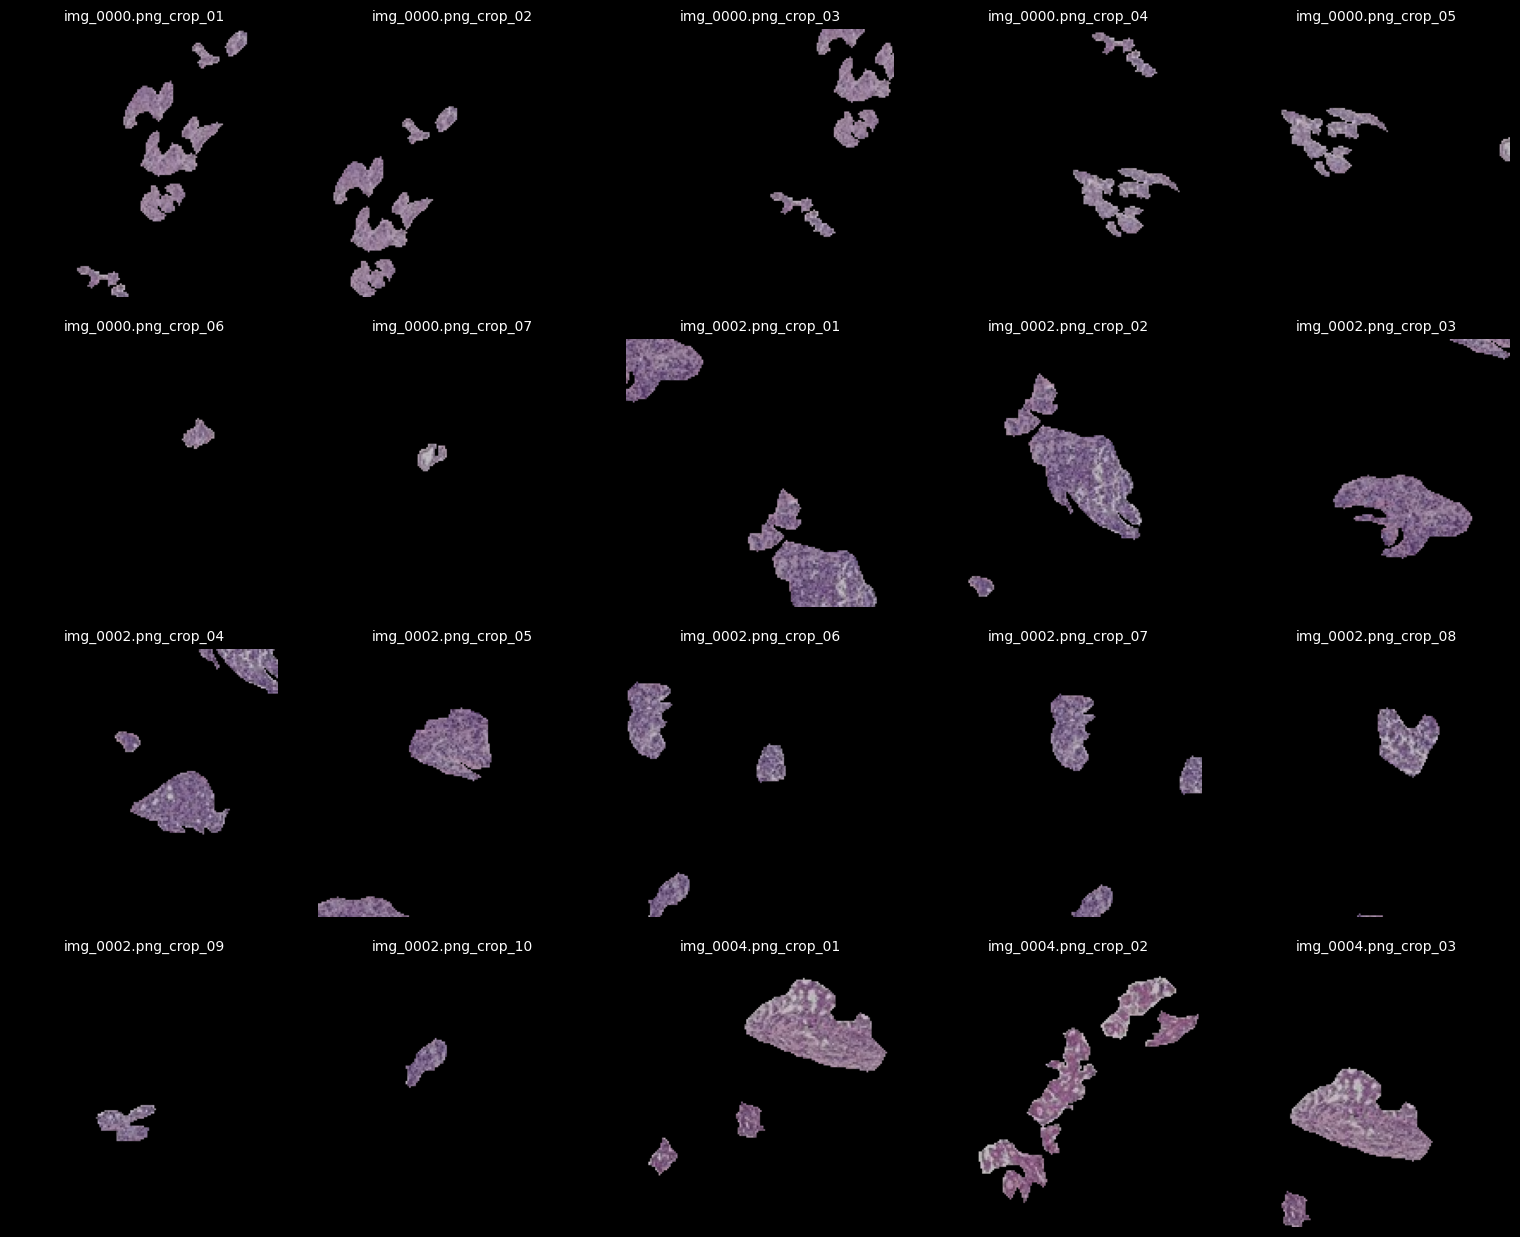

In [23]:
plot_images(X_c_train, index_column = 'crop_index')

In [24]:
class_counts = y_c_train['label'].value_counts().sort_index()
total = class_counts.sum()

# Compute class weights
class_weights = total / class_counts
class_weights = class_weights / class_weights.sum()  # normalize
class_weights = torch.tensor(class_weights.values, dtype = torch.float32).to(device)

print(f"Class weights: {class_weights}")

Class weights: tensor([0.1943, 0.1945, 0.1498, 0.4614], device='cuda:0')


In [25]:
# Extract labels for each sample
labels_np = y_c_train['label'].values.astype(int)
labels_tensor = torch.from_numpy(labels_np)  # shape: (N,)

# Class weights
counts_tensor = torch.tensor(class_counts.values, dtype = torch.float32)  # shape: (num_classes,)
class_inv_freq = 1.0 / torch.sqrt(counts_tensor)
# Sample weights
sample_weights = class_inv_freq[labels_tensor]  # shape: (N,)

train_sampler = WeightedRandomSampler(
    weights = sample_weights,
    num_samples = len(sample_weights),
    replacement = True,
)

### PyTorch datasets

In [26]:
# Define the input shape based on the training data
H, W, C = load_image(X_c_train.loc[0, 'image_path']).shape
input_shape = (C, H, W)

# Define the number of classes
num_classes = len(np.unique(y_c_train['label']))

print("Input Shape:", input_shape)
print("Number of Classes:", num_classes)

Input Shape: (4, 156, 156)
Number of Classes: 4


In [27]:
class PatchTensorDataset(Dataset):
    def __init__(self, images, img_ids, labels = None):
        # (N, C, H, W)
        self.images = torch.from_numpy(images).permute(0, 3, 1, 2).float()

        self.img_ids = list(img_ids)

        if labels is not None:
            self.labels = torch.from_numpy(labels).long()
        else:
            self.labels = None

    def __len__(self):
        return self.images.size(0)

    def __getitem__(self, idx):
        x = self.images[idx]
        img_id = self.img_ids[idx]

        if self.labels is None:
            # Test set: no labels
            return img_id, x
        else:
            y = self.labels[idx]
            return img_id, x, y

In [28]:
train_ids = X_c_train['sample_index'].to_numpy()
val_ids   = X_c_val['sample_index'].to_numpy()
test_ids  = X_c_test['sample_index'].to_numpy()

X_train_array = np.stack(X_c_train['image_path'].apply(lambda i: load_image(i)).values)
X_val_array   = np.stack(X_c_val['image_path']  .apply(lambda i: load_image(i)).values)
X_test_array  = np.stack(X_c_test['image_path'] .apply(lambda i: load_image(i)).values)

y_train_array = np.array(y_c_train['label'])
y_val_array   = np.array(y_c_val['label'])

# Convert numpy arrays to PyTorch datasets (without augmentation for now)
train_ds_base = PatchTensorDataset(
    images  = X_train_array,
    img_ids = train_ids,
    labels  = y_train_array
)

val_ds_base = PatchTensorDataset(
    images  = X_val_array,
    img_ids = val_ids,
    labels  = y_val_array
)

test_ds_base = PatchTensorDataset(
    images  = X_test_array,
    img_ids = test_ids,
    labels  = None
)

Train patches per classe:
  HER2(+): 1040 patch (26.9%)
  Luminal A: 1039 patch (26.9%)
  Luminal B: 1349 patch (34.9%)
  Triple negative: 438 patch (11.3%)

Val patches per classe:
  HER2(+): 246 patch (25.3%)
  Luminal A: 268 patch (27.6%)
  Luminal B: 346 patch (35.6%)
  Triple negative: 111 patch (11.4%)


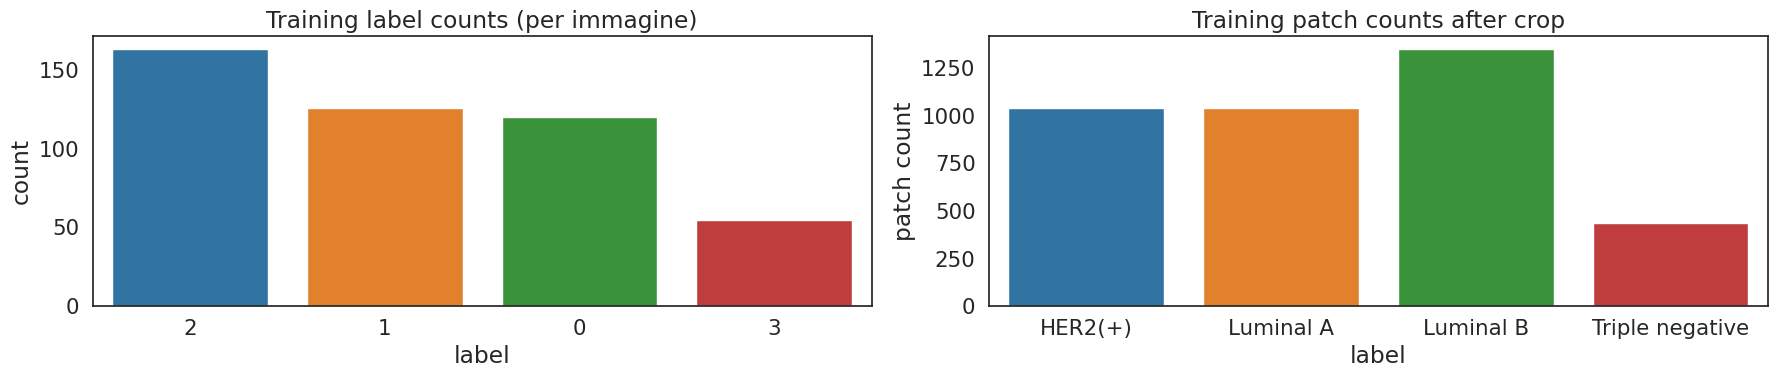

In [29]:
# Patches counts
train_counts = Counter(y_train_array.tolist())
val_counts   = Counter(y_val_array.tolist())

classes      = sorted(train_counts.keys())
class_names  = [int_to_label[c] for c in classes]

print("Train patches per classe:")
train_total = len(y_train_array)
for c in classes:
    name = int_to_label[c]
    cnt = train_counts[c]
    print(f"  {name}: {cnt} patch ({cnt / train_total * 100:.1f}%)")

print("\nVal patches per classe:")
val_total = len(y_val_array)
for c in classes:
    name = int_to_label[c]
    cnt = val_counts[c]
    print(f"  {name}: {cnt} patch ({cnt / val_total * 100:.1f}%)")

plt.figure(figsize = (18, 4))

# Image level
plt.subplot(1, 2, 1)
sns.countplot(
    x = 'label',
    data = y_train,
    order = y_train['label'].value_counts().index,
    palette = "tab10"
)
plt.title("Training label counts (per immagine)")
plt.xlabel("label")
plt.ylabel("count")

# Patch level
plt.subplot(1, 2, 2)
sns.barplot(
    x = class_names,
    y = [train_counts[c] for c in classes],
    palette="tab10"
)
plt.title("Training patch counts after crop")
plt.xlabel("label")
plt.ylabel("patch count")

plt.tight_layout()
plt.show()

## 🦃 **Image Augmentation**

### Geometric and color augmentation

In [30]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

class ImageNetNormalize:
    """
    Normalize RGB channels with ImageNet mean/std.
    """
    def __init__(self, mean = IMAGENET_MEAN, std = IMAGENET_STD):
        self.mean = torch.tensor(mean, dtype=torch.float32).reshape(3, 1, 1)
        self.std = torch.tensor(std, dtype=torch.float32).reshape(3, 1, 1)

    def __call__(self, image):
        if C == 2:
            # grayscale + mask
            gray = image[0:1]            # (1, H, W)
            rgb = gray.repeat(3, 1, 1)   # (3, H, W)
            mask = image[1:2]            # (1, H, W)
        elif C == 4:
            # RGB + mask
            rgb = image[0:3]             # (3, H, W)
            mask = image[3:4]            # (1, H, W)
        else:
            raise ValueError("Input must have 2 or 4 channels")

        # Normalize only RGB
        rgb_normalized = (rgb - self.mean) / self.std

        return torch.cat([rgb_normalized, mask], dim = 0)

In [31]:
class AugmentedDataset(torch.utils.data.Dataset):
    """
    Dataset wrapper that applies augmentation transforms to images.
    """
    def __init__(self, base_dataset, transform = None):
        self.base_dataset = base_dataset
        self.transform = transform

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        sample = self.base_dataset[idx]

        if len(sample) == 3:
            # Training/validation: (img_id, image, label)
            img_id, image, label = sample
            if self.transform:
                image = self.transform(image)
            return img_id, image, label

        elif len(sample) == 2:
            # Test: (img_id, image)
            img_id, image = sample
            if self.transform:
                image = self.transform(image)
            return img_id, image

        else:
            raise ValueError(f"Unexpected sample length: {len(sample)}")


In [32]:
class RandAugment:
    """
    RandAugment for histopathology (stain-safe).
    """
    def __init__(self):
        # Geometric ops
        self.geometric_ops = [
            ("rotate", lambda image, mag: transforms.functional.rotate(
                image, angle = float(mag) * 25 - 12.5,
                interpolation = transforms.InterpolationMode.BILINEAR
            )),
            ("translate_x", lambda image, mag: transforms.functional.affine(
                image, angle = 0, translate = [int(mag * image.shape[-1] * 0.15), 0],
                scale = 1.0, shear = 0, interpolation = transforms.InterpolationMode.BILINEAR
            )),
            ("translate_y", lambda image, mag: transforms.functional.affine(
                image, angle = 0, translate = [0, int(mag * image.shape[-2] * 0.15)],
                scale = 1.0, shear = 0, interpolation = transforms.InterpolationMode.BILINEAR
            )),
            ("shear_x", lambda image, mag: transforms.functional.affine(
                image, angle = 0, translate = [0,0],
                scale = 1.0, shear = [float(mag) * 15 - 7.5, 0],
                interpolation = transforms.InterpolationMode.BILINEAR
            )),
            ("shear_y", lambda image, mag: transforms.functional.affine(
                image, angle = 0, translate = [0,0],
                scale = 1.0, shear = [0, float(mag) * 15 - 7.5],
                interpolation = transforms.InterpolationMode.BILINEAR
            )),
        ]

        # Color ops
        self.color_ops = [
            ("brightness", lambda image, mag: transforms.functional.adjust_brightness(
                image, 1.0 + float(mag) * 0.15 - 0.075
            )),
            ("contrast", lambda image, mag: transforms.functional.adjust_contrast(
                image, 1.0 + float(mag) * 0.15 - 0.075
            )),
        ]

In [33]:
class ImageRandAugment:
    """
    RandAugment for images (img + mask).
    """
    def __init__(self,
                 n_geometric = 2,
                 n_color = 2,
                 mag_geometric = 10,
                 mag_color = 8):
        self.rand_augment = RandAugment()
        self.n_geometric = n_geometric
        self.n_color = n_color
        self.mag_geometric = mag_geometric
        self.mag_color = mag_color

        # Base geometric transforms (flips)
        self.base_geometric = transforms.Compose([
            transforms.RandomHorizontalFlip(p = 0.5),
            transforms.RandomVerticalFlip(p = 0.5),
        ])

    def __call__(self, image):
        # Apply flips to all channels
        image = self.base_geometric(image)

        # Apply geometric RandAugment to all channels
        if self.n_geometric > 0:
            ops = random.choices(self.rand_augment.geometric_ops, k = self.n_geometric)
            for _, op in ops:
                mag = random.uniform(0, self.mag_geometric) / self.mag_geometric
                image = op(image, mag)

        # Split img and mask
        C = image.shape[0]
        img  = image[:(C - 1), :, :]
        mask = image[-1:, :, :]

        # Apply color RandAugment only to img
        if self.n_color > 0:
            ops = random.choices(self.rand_augment.color_ops, k = self.n_color)
            for _, op in ops:
                mag = random.uniform(0, self.mag_color) / self.mag_color
                img = op(img, mag)

        return torch.cat([img, mask], dim = 0)

In [34]:
# Create transform
train_transform = ImageRandAugment(
    n_geometric = N_GEOMETRIC,
    n_color = N_COLOR,
    mag_geometric = MAG_GEOMETRIC,
    mag_color = MAG_COLOR
)

normalize_transform = ImageNetNormalize()

In [35]:
# Apply augmentation + normalization
train_ds_aug = AugmentedDataset(
    train_ds_base,
    transform = transforms.Compose([
        train_transform,
        normalize_transform
    ])
)

# Apply only normalization
val_ds_aug = AugmentedDataset(
    val_ds_base,
    transform = normalize_transform
)

test_ds_aug = AugmentedDataset(
    test_ds_base,
    transform = normalize_transform
)

print(f"Training:   {len(train_ds_aug):>6,} samples (with RandAugment)")
print(f"Validation: {len(val_ds_aug):>6,} samples (no augmentation)")
print(f"Test:       {len(test_ds_aug):>6,} samples (no augmentation)")

Training:    3,866 samples (with RandAugment)
Validation:    971 samples (no augmentation)
Test:        3,968 samples (no augmentation)


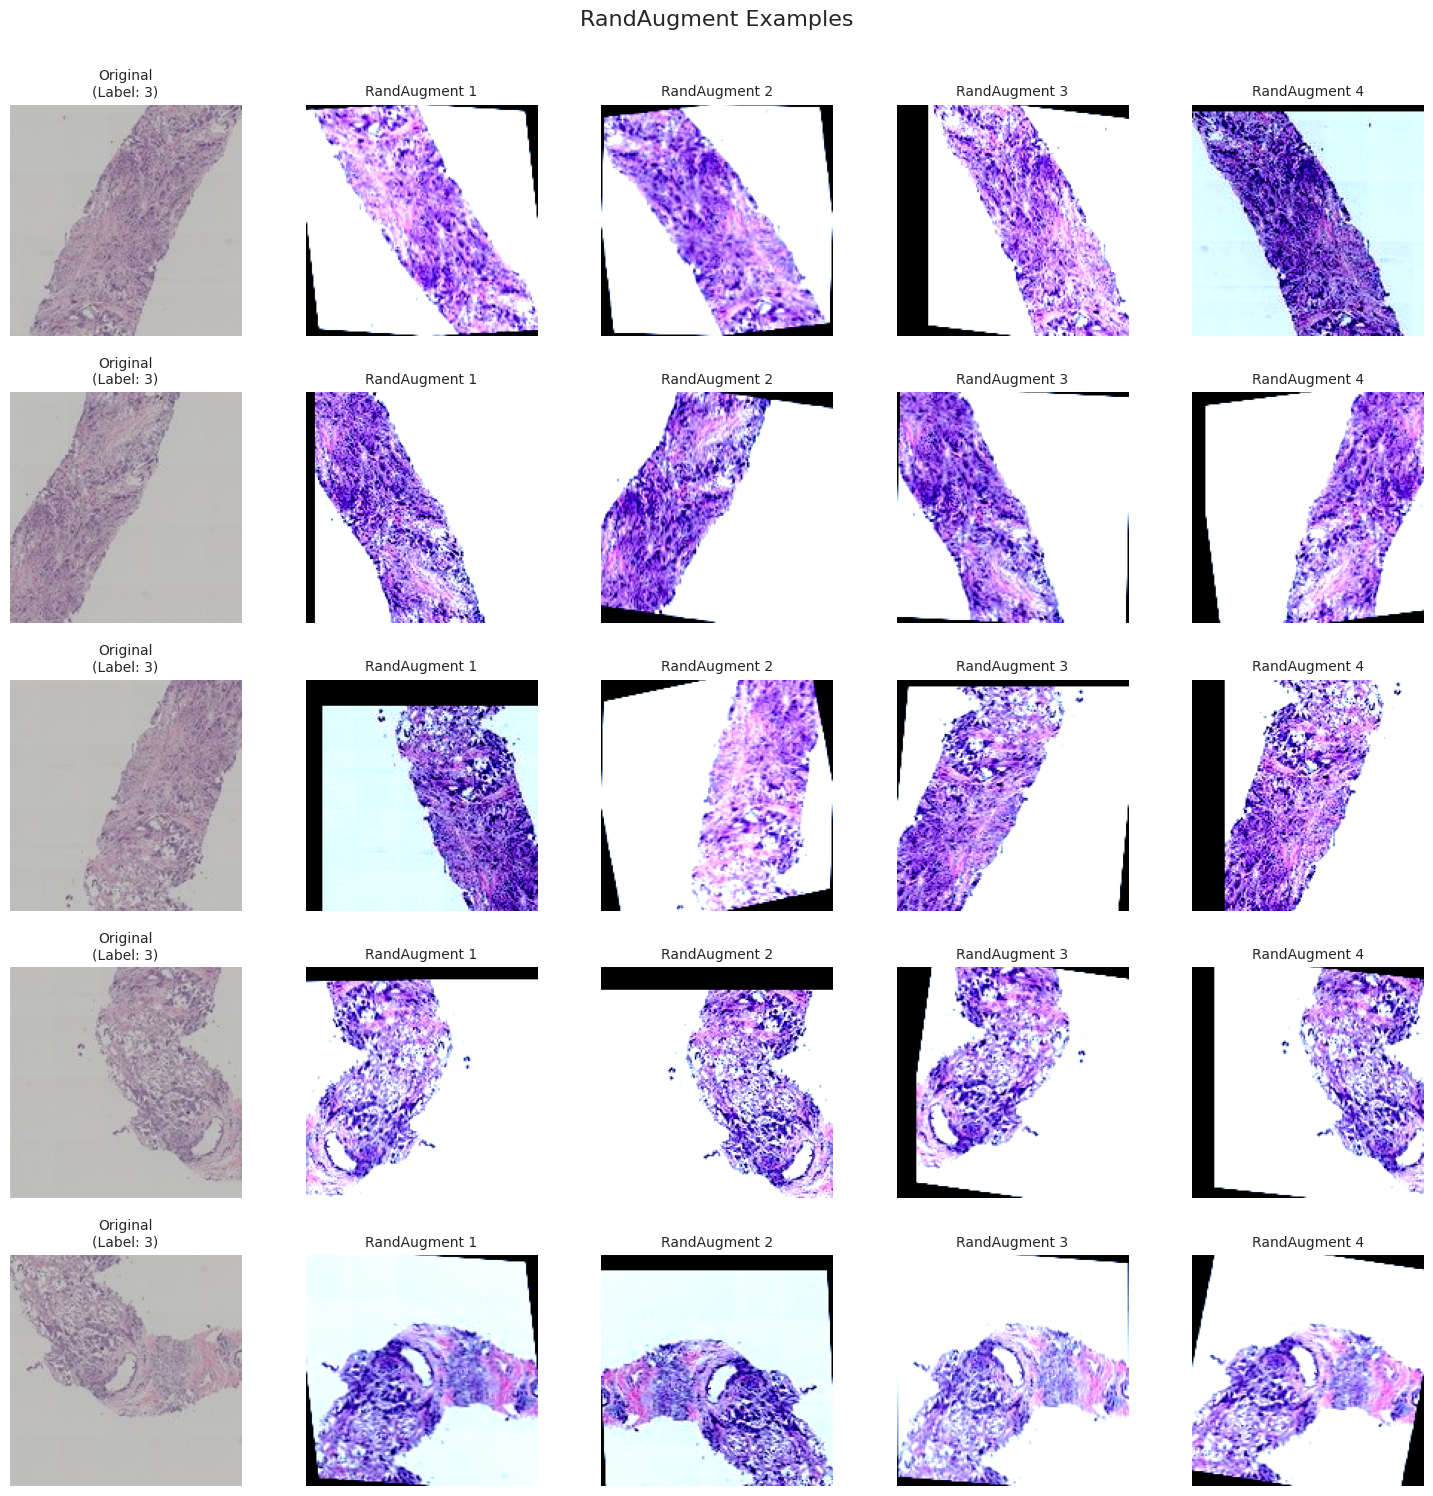

In [36]:
def visualize_augmentations(dataset,
                            num_samples = 5,
                            augmentations_per_sample = 4):
    """
    Visualize original and augmented versions of training samples.

    Args:
        dataset: AugmentedDataset instance
        num_samples: Number of different samples to show
        augmentations_per_sample: Number of augmented versions per sample
    """
    fig, axes = plt.subplots(
        num_samples,
        augmentations_per_sample + 1,
        figsize = (3 * (augmentations_per_sample + 1), 3 * num_samples),
        facecolor = "white"
    )

    # Handle single row case
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_samples):
        # Get original sample (before augmentation)
        _, image, label = dataset.base_dataset[i]

        # Remove mask
        image = image[:(C - 1)]

        # Show original
        image = image.permute(1, 2, 0).numpy()
        axes[i, 0].imshow(np.clip(image, 0, 1))
        axes[i, 0].set_title(f"Original\n(Label: {label.item()})", fontsize = 10)
        axes[i, 0].axis('off')

        # Show augmented versions
        for j in range(augmentations_per_sample):
            _, image_aug, _ = dataset[i]

            # Remove mask
            image_aug = image_aug[:(C - 1)]

            image_aug = image_aug.permute(1, 2, 0).numpy()
            axes[i, j + 1].imshow(np.clip(image_aug, 0, 1))
            axes[i, j + 1].set_title(f"RandAugment {j+1}", fontsize = 10)
            axes[i, j + 1].axis('off')

    plt.suptitle("RandAugment Examples", fontsize = 16, y = 0.998)
    plt.tight_layout()
    plt.show()

visualize_augmentations(train_ds_aug, num_samples = 5, augmentations_per_sample = 4)

### Create data loaders

In [37]:
def make_loader(ds, batch_size, shuffle, drop_last, sampler = None):
    """
    Create a PyTorch DataLoader with optimized settings.

    Args:
        ds (Dataset): PyTorch Dataset object
        batch_size (int): Number of samples per batch
        shuffle (bool): Whether to shuffle data at each epoch (ignored if sampler is not None)
        drop_last (bool): Whether to drop last incomplete batch
        sampler (Sampler or None): Optional PyTorch sampler (e.g. WeightedRandomSampler)

    Returns:
        DataLoader: Configured DataLoader instance
    """
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    return DataLoader(
        ds,
        batch_size = batch_size,
        shuffle = (sampler is None and shuffle),
        sampler = sampler,
        drop_last = drop_last,
        num_workers = num_workers,
        pin_memory = True,  # Faster GPU transfer
        pin_memory_device = "cuda" if torch.cuda.is_available() else "",
        prefetch_factor = 4,  # Load 4 batches ahead
    )

# Create data loaders
train_loader = make_loader(train_ds_aug, batch_size = BATCH_SIZE, shuffle = True,  drop_last = False, sampler = train_sampler)
val_loader   = make_loader(val_ds_aug,   batch_size = BATCH_SIZE, shuffle = False, drop_last = False)
test_loader  = make_loader(test_ds_aug,  batch_size = BATCH_SIZE, shuffle = False, drop_last = False)

## 🛠️ **Model Building**

In [38]:
class BaseCNN(nn.Module):
    def __init__(self,
                 input_shape = (3, 224, 224),
                 num_classes = 4,
                 norm_type = None,
                 dropout_rate = 0.2):
        super().__init__()

        allowed_norms = {"none", "batch", "layer", "instance"}
        norm_key = (norm_type or "none").lower()
        if norm_key not in allowed_norms:
            raise ValueError(
                f"Unsupported norm_type '{norm_type}'. Choose from {allowed_norms}."
            )
        self.norm_type = norm_key

        self.conv0 = nn.Conv2d(input_shape[0], 32, kernel_size=3, padding=1)
        self.bn0 = self._make_norm_layer(32)
        self.relu0 = nn.ReLU()
        self.conv1 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn1 = self._make_norm_layer(64)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = self._make_norm_layer(128)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = self._make_norm_layer(256)
        self.relu3 = nn.ReLU()

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_rate)

        # Compute flatten size dynamically for fully connected layer
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            x = self._forward_features(dummy_input)
            self.flattened_size = x.view(1, -1).shape[1]

        self.fc = nn.Linear(self.flattened_size, num_classes)

    def _make_norm_layer(self, channels):
        if self.norm_type == "batch":
            return nn.BatchNorm2d(channels)
        elif self.norm_type == "layer":
            return nn.GroupNorm(1, channels)  # LayerNorm for 2D
        elif self.norm_type == "instance":
            return nn.InstanceNorm2d(channels, affine=True)
        else:
            return nn.Identity()

    def _forward_features(self, x):
        x = self.relu0(self.bn0(self.conv0(x)))
        x = self.pool(x)
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu3(self.bn3(self.conv3(x)))
        x = self.pool(x)
        return x

    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [39]:

from typing import Optional
import torch
import torch.nn as nn
import torch.nn.functional as F


class TransferLearningNet(nn.Module):
    """
    ResNet/VGG backbone used as frozen feature extractor + MLP classifier head.

    - Expects input tensor x of shape (B, C, H, W) where C == 3 or 4.
      If C == 4, the last channel is the mask (values in [0,1]) but it is IGNORED.
      If C == 3, it is used as-is.
      **ImageNet normalization MANDATORY on RGB in dataset**.

    - The ResNet/VGG backbone (up to features/layer4) extracts generic features.
    - A small MLP head operates on pooled features → logits num_classes.
    """

    def __init__(self,
                 num_classes = 4,
                 backbone = "vgg16",
                 pretrained = True,
                 freeze_backbone = "partial",  # "none", "partial", "all"
                 mask_strength = 1.0,
                 dropout_rate = 0.3):
        """
        Args:
            num_classes: number of output classes.
            backbone: name of torchvision backbone ("resnet18/34/50/101", "vgg16").
            pretrained: if True load best pretrained weights (no deprecation warning).
            freeze_backbone:
                - "none"    → full fine-tuning.
                - "partial" → freeze early blocks (conv1/bn1/layer1/layer2 for ResNet).
                - "all"     → use backbone only as frozen feature extractor.
            dropout_rate: dropout rate inside the MLP classifier.
        """
        super().__init__()

        if freeze_backbone not in {"none", "partial", "all"}:
            raise ValueError(f"Unsupported freeze option '{freeze_backbone}'")

        # ------------------------------------------------------------
        # 1) Backbone selection
        # ------------------------------------------------------------
        backbone_dict = {
            "resnet18":  (models.resnet18,  models.ResNet18_Weights.IMAGENET1K_V1),
            "resnet34":  (models.resnet34,  models.ResNet34_Weights.IMAGENET1K_V1),
            "resnet50":  (models.resnet50,  models.ResNet50_Weights.IMAGENET1K_V2),
            "resnet101": (models.resnet101, models.ResNet101_Weights.IMAGENET1K_V2),
            "vgg16":     (models.vgg16_bn,  models.VGG16_BN_Weights.IMAGENET1K_V1),
            "vgg19":     (models.vgg19_bn,  models.VGG19_BN_Weights.IMAGENET1K_V1),
        }

        if backbone not in backbone_dict:
            raise ValueError(f"Unsupported backbone '{backbone}'")

        model_func, weights = backbone_dict[backbone]
        backbone_model = model_func(weights = weights if pretrained else None)

        # ------------------------------------------------------------
        # 2) Feature extractor
        # ------------------------------------------------------------
        if backbone.startswith("resnet"):
            self.feature_extractor = nn.Sequential(
                backbone_model.conv1,
                backbone_model.bn1,
                backbone_model.relu,
                backbone_model.maxpool,
                backbone_model.layer1,
                backbone_model.layer2,
                backbone_model.layer3,
                backbone_model.layer4
            )
            self.feat_channels = backbone_model.fc.in_features

        elif backbone.startswith("vgg"):
            self.feature_extractor = backbone_model.features
            self.feat_channels = 512  # VGG16 features output 512 channels

        # ------------------------------------------------------------
        # 3) Classification head
        # ------------------------------------------------------------
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.feat_channels, 512),
            nn.ReLU(inplace = True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(inplace = True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes),
        )

        # ------------------------------------------------------------
        # 4) Freeze backbone parameters
        # ------------------------------------------------------------
        if freeze_backbone == "all":
            for p in backbone_model.parameters():
                p.requires_grad = False

        elif freeze_backbone == "partial":
            if backbone.startswith("resnet"):
                # Freeze low-level blocks: conv1, bn1, layer1, layer2
                for name, p in backbone_model.named_parameters():
                    if any(name.startswith(pref) for pref in ["conv1", "bn1", "layer1", "layer2", "layer3"]):
                        p.requires_grad = False

            elif backbone.startswith("vgg"):
                # Freeze first half of VGG features (very generic filters)
                num_features = len(backbone_model.features)
                for i, m in enumerate(backbone_model.features):
                    if i < num_features // 2:
                        for p in m.parameters():
                            p.requires_grad = False

        # ------------------------------------------------------------
        # 5) Re-initialize classifier
        # ------------------------------------------------------------
        self.mask_strength = mask_strength
        self._init_weights()

    def _init_weights(self):
        # Initialize only newly added Linear layers inside classifier
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor):
        """
        x: tensor (B, C, H, W)
        """
        B, C, H, W = x.shape

        # Split RGB and mask
        rgb = x[:, :3]
        mask = x[:, -1:]

        # Backbone conv features
        feat = self.feature_extractor(rgb)   # (B, feat_channels, Hf, Wf)
        _, _, Hf, Wf = feat.shape

        # Resize mask to feature map size
        mask_small = F.interpolate(mask, size = (Hf, Wf), mode = "nearest")

        # Normalize mask so background doesn't kill signal
        mask_small = mask_small.float()

        # Masked average pooling
        attn = 1.0 + self.mask_strength * mask_small
        pooled = F.adaptive_avg_pool2d(feat * attn, (1, 1)).view(x.size(0), -1)

        logits = self.classifier(pooled)
        return logits

In [40]:
if BACKBONE is not None:
    cnn_model = TransferLearningNet(
        num_classes,
        backbone = BACKBONE,
        pretrained = PRETRAINED,
        freeze_backbone = FREEZE_BACKBONE,
        mask_strength = MASK_STRENGTH,
        dropout_rate = DROPOUT_RATE
    ).to(device)

else:
    cnn_model = BaseCNN(
        input_shape,
        num_classes,
        dropout_rate = DROPOUT_RATE
    ).to(device)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


100%|██████████| 548M/548M [00:06<00:00, 83.3MB/s]


In [41]:
# Set up TensorBoard logging and save model architecture
experiment_name = "vgg19"
writer = SummaryWriter("./" + logs_dir + "/" + experiment_name)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled = (device.type == "cuda"))

In [42]:
optimizer_dict = {
    "adam":   torch.optim.Adam(      cnn_model.parameters(), lr = LEARNING_RATE, weight_decay = L2_LAMBDA),
    "adamW":  torch.optim.AdamW(     cnn_model.parameters(), lr = LEARNING_RATE, weight_decay = L2_LAMBDA),
    "ranger": torch_optimizer.Ranger(cnn_model.parameters(), lr = LEARNING_RATE, weight_decay = L2_LAMBDA),
    "lion":   Lion(                  cnn_model.parameters(), lr = LEARNING_RATE, weight_decay = L2_LAMBDA),
}

# Loss function selection
try:
    optimizer = optimizer_dict[OPTIMIZER]
except KeyError:
    raise ValueError(f"Optimizer '{OPTIMIZER}' not recognized")

In [43]:
class FocalLoss(nn.Module):
    """
    Focal Loss for addressing class imbalance.
    Focuses on hard-to-classify examples.
    """
    def __init__(self, alpha = None, gamma = 2.0, label_smoothing = 0.0, reduction = "mean"):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.label_smoothing = label_smoothing
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Get cross entropy loss
        ce_loss = nn.functional.cross_entropy(
            inputs,
            targets,
            reduction = "none",
            label_smoothing = self.label_smoothing
        )

        # Calculate focal weight
        pt = torch.exp(-ce_loss)
        focal_weight = (1 - pt) ** self.gamma
        focal_loss = focal_weight * ce_loss

        # Apply class weights if provided
        if self.alpha is not None:
            if self.alpha.device != inputs.device:
                self.alpha = self.alpha.to(inputs.device)
            alpha_t = self.alpha[targets]
            focal_loss = alpha_t * focal_loss

        # Apply reduction
        if self.reduction == "mean":
            return focal_loss.mean()
        elif self.reduction == "sum":
            return focal_loss.sum()
        else:
            return focal_loss

In [44]:
loss_dict = {
    "CE": nn.CrossEntropyLoss(label_smoothing = LABEL_SMOOTHING),
    "wCE": nn.CrossEntropyLoss(label_smoothing = LABEL_SMOOTHING, weight = class_weights),
    "focal": FocalLoss(alpha = None, gamma = 2.0, label_smoothing = LABEL_SMOOTHING),
    "wFocal": FocalLoss(alpha = class_weights, gamma = 2.0, label_smoothing = LABEL_SMOOTHING),
}

# Loss function selection
try:
    criterion = loss_dict[CRITERION]
except KeyError:
    raise ValueError(f"CRITERION '{CRITERION}' not recognized. Available options: {list(loss_dict.keys())}")

## 🧠 **Model Training**

In [45]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda = 0, l2_lambda = 0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (_, inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none = True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type = device.type, enabled = (device.type == "cuda")):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters() if p.requires_grad)
            l2_norm = sum(p.pow(2).sum() for p in model.parameters() if p.requires_grad)
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm

        # Backward pass with gradient scaling
        scaler.scale(loss).backward()

        # Gradient clipping (AFTER unscale, BEFORE optimizer step)
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)

        # Optimizer step with scaled gradients
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim = 1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average = "weighted"
    )

    return epoch_loss, epoch_f1

In [46]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, f1 score) - Validation loss and f1 score for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0

    # Accumulators for image-level aggregation
    image_probs = {}   # img_id -> list of prob vectors (one per patch)
    image_targets = {} # img_id -> single ground-truth label

    # Disable gradient computation for validation
    with torch.no_grad():
        for img_ids, inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type = device.type,
                                    enabled = (device.type == "cuda")):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate loss (patch-level)
            running_loss += loss.item() * inputs.size(0)

            # Convert logits to probabilities and move to CPU/NumPy
            probs = torch.softmax(logits, dim = 1).cpu().numpy()
            targets_np = targets.cpu().numpy()

            # Accumulate per-image patch predictions
            for img_id, p, t in zip(img_ids, probs, targets_np):
                # Ensure img_id is a hashable scalar (e.g., Python int)
                if isinstance(img_id, torch.Tensor):
                    img_id = img_id.item()

                if img_id not in image_probs:
                    image_probs[img_id] = []
                    image_targets[img_id] = t

                image_probs[img_id].append(p)

    # Image-level aggregation
    final_preds = []
    final_targets = []

    for img_id in image_probs:
        mean_prob = np.mean(image_probs[img_id], axis = 0)
        pred = np.argmax(mean_prob)
        target = image_targets[img_id]

        final_preds.append(pred)
        final_targets.append(target)

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_f1 = f1_score(
        final_targets,
        final_preds,
        average = "weighted"
    )

    return epoch_loss, epoch_f1

In [47]:
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty before adding a histogram
            if param.numel() > 0:
                writer.add_histogram(f"{name}/weights", param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty before adding a histogram
                if param.grad.numel() > 0:
                    if param.grad is not None and torch.isfinite(param.grad).all():
                        writer.add_histogram(f"{name}/gradients", param.grad.data, epoch)

In [48]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda = 0, l2_lambda = 0, patience = 0, evaluation_metric = "val_f1", mode = "max",
        restore_best_weights = True, writer = None, verbose = 10, experiment_name = ""):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        "train_loss": [], "val_loss": [],
        "train_f1": [], "val_f1": []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float("-inf") if mode == "max" else float("inf")
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    try:
        # Main training loop: iterate through epochs
        for epoch in range(1, epochs + 1):

            # Forward pass through training data, compute gradients, update weights
            train_loss, train_f1 = train_one_epoch(
                model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
            )

            # Evaluate model on validation data without updating weights
            val_loss, val_f1 = validate_one_epoch(
                model, val_loader, criterion, device
            )

            # Store metrics for plotting and analysis
            training_history['train_loss'].append(train_loss)
            training_history['val_loss'].append(val_loss)
            training_history['train_f1'].append(train_f1)
            training_history['val_f1'].append(val_f1)

            # Write metrics to TensorBoard for visualization
            if writer is not None:
                log_metrics_to_tensorboard(
                    writer, epoch, train_loss, train_f1, val_loss, val_f1, model
                )

            # Print progress every N epochs or on first epoch
            if verbose > 0:
                if epoch % verbose == 0 or epoch == 1:
                    print(f"Epoch {epoch:3d}/{epochs} | "
                        f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                        f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

            # Early stopping logic: monitor metric and save best model
            if patience > 0:
                current_metric = training_history[evaluation_metric][-1]
                is_improvement = (current_metric > best_metric) if mode == "max" else (current_metric < best_metric)

                if is_improvement:
                    best_metric = current_metric
                    best_epoch = epoch
                    torch.save(model.state_dict(), "models/" + experiment_name + "_model.pt")
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print(f"Early stopping triggered after {epoch} epochs.")
                        break

    except KeyboardInterrupt:
        print("Training interrupted by user. Saving current model...")

        # save model even if interrupted
        torch.save(model.state_dict(), "models/" + experiment_name + "_interrupted.pt")

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/" + experiment_name + "_model.pt"))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/" + experiment_name + "_model.pt")

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

In [49]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total params:     {total:,}")
    print(f"Trainable params: {trainable:,}")
    print(f"Frozen params:    {total - trainable:,}")

count_parameters(cnn_model)

Total params:     20,430,404
Trainable params: 18,102,020
Frozen params:    2,328,384


In [50]:
%%time
# Train model and track training history
final_model, history = fit(
    model = cnn_model,
    train_loader = train_loader,
    val_loader = val_loader,
    epochs = EPOCHS,
    criterion = criterion,
    optimizer = optimizer,
    scaler = scaler,
    device = device,
    writer = writer,
    verbose = 1,
    experiment_name = experiment_name,
    patience = PATIENCE
)

Training 500 epochs...
Epoch   1/500 | Train: Loss=0.1763, F1 Score=0.2053 | Val: Loss=0.1630, F1 Score=0.0239
Epoch   2/500 | Train: Loss=0.1771, F1 Score=0.1227 | Val: Loss=0.1630, F1 Score=0.0256
Epoch   3/500 | Train: Loss=0.1786, F1 Score=0.0607 | Val: Loss=0.1630, F1 Score=0.0256
Epoch   4/500 | Train: Loss=0.1761, F1 Score=0.0502 | Val: Loss=0.1629, F1 Score=0.0256
Epoch   5/500 | Train: Loss=0.1771, F1 Score=0.0523 | Val: Loss=0.1627, F1 Score=0.0256
Epoch   6/500 | Train: Loss=0.1736, F1 Score=0.0477 | Val: Loss=0.1621, F1 Score=0.0256
Epoch   7/500 | Train: Loss=0.1735, F1 Score=0.0538 | Val: Loss=0.1586, F1 Score=0.0256
Epoch   8/500 | Train: Loss=0.1640, F1 Score=0.0495 | Val: Loss=0.1571, F1 Score=0.0256
Epoch   9/500 | Train: Loss=0.1581, F1 Score=0.0480 | Val: Loss=0.1627, F1 Score=0.0256
Epoch  10/500 | Train: Loss=0.1543, F1 Score=0.0502 | Val: Loss=0.1548, F1 Score=0.0256
Epoch  11/500 | Train: Loss=0.1494, F1 Score=0.0516 | Val: Loss=0.1543, F1 Score=0.0256
Epoch  12

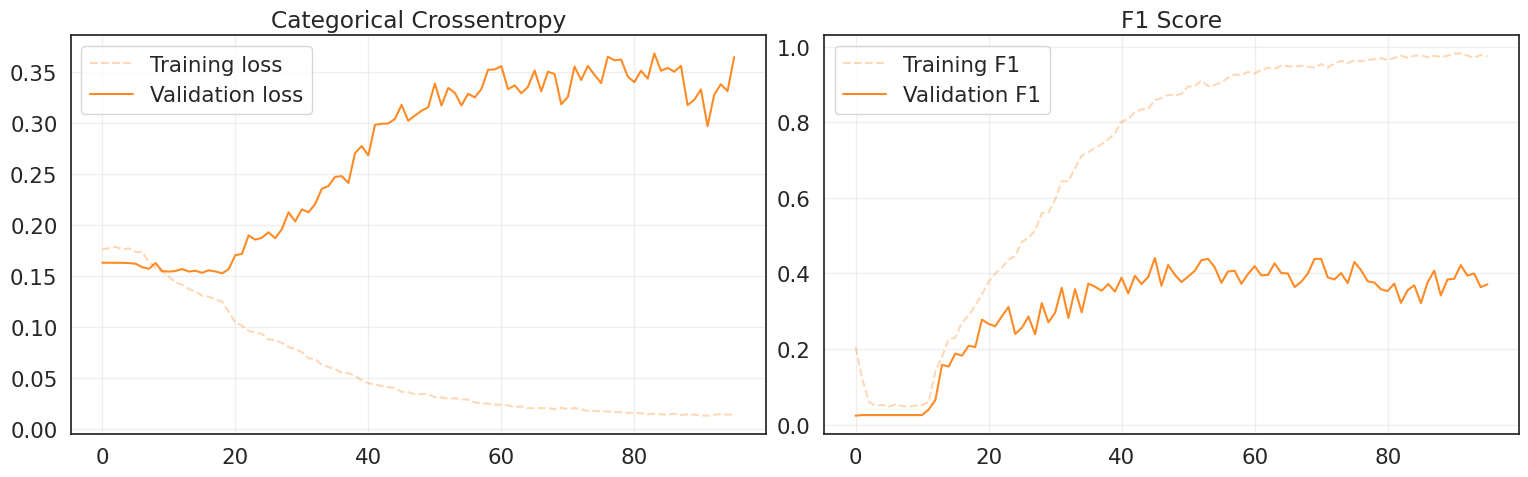

In [51]:
# Create a figure with two side-by-side subplots
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(history['train_loss'], label = "Training loss",   alpha = 0.3, color = "#ff7f0e", linestyle = "--")
ax1.plot(history['val_loss'],   label = "Validation loss", alpha = 0.9, color = "#ff7f0e")
ax1.set_title("Categorical Crossentropy")
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation F1 score on the second axis
ax2.plot(history['train_f1'], label = "Training F1",   alpha = 0.3, color = "#ff7f0e", linestyle = "--")
ax2.plot(history['val_f1'],   label = "Validation F1", alpha = 0.9, color = "#ff7f0e")
ax2.set_title("F1 Score")
ax2.legend()
ax2.grid(alpha = 0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right = 0.85)
plt.show()

In [52]:
def tta_logits(model, x):
    """
    Simple Test-Time Augmentation:
    - original
    - horizontal flip
    - vertical flip
    Averages logits across these 3 variants.
    x: (B, C, H, W)
    """
    logits_list = []

    # Original
    logits_list.append(model(x))

    # Horizontal flip
    x_h = torch.flip(x, dims = [-1])
    logits_list.append(model(x_h))

    # Vertical flip
    x_v = torch.flip(x, dims = [-2])
    logits_list.append(model(x_v))

    return torch.mean(torch.stack(logits_list, dim = 0), dim = 0)

PATCH LEVEL METRICS
Accuracy over the validation set: 0.4016
Precision over the validation set: 0.4191
Recall over the validation set: 0.4016
F1 score over the validation set: 0.3958


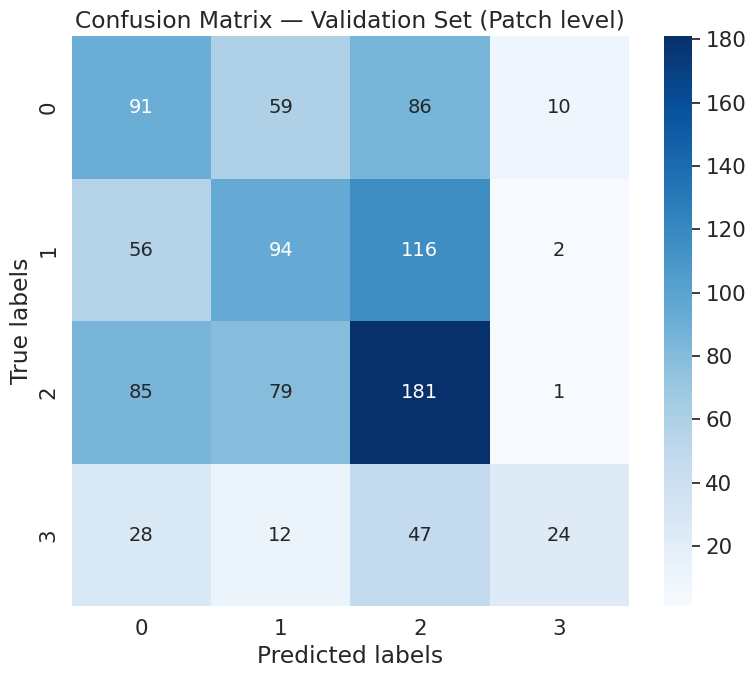

In [53]:
final_model.eval()

val_preds, val_targets = [], []
with torch.no_grad():  # Disable gradient computation for inference
    for _, inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type = device.type, enabled = (device.type == "cuda")):
            logits = final_model(inputs)
            loss = criterion(logits, targets)

        # Accumulate metrics
        preds = logits.argmax(dim = 1)

        # Store batch results
        val_preds.append(preds.cpu().numpy())
        val_targets.append(targets.cpu().numpy())

# Combine all batches into single arrays
val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Calculate overall validation metrics
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average = "weighted")
val_rec = recall_score(val_targets, val_preds, average = "weighted")
val_f1 = f1_score(val_targets, val_preds, average = "weighted")
print("PATCH LEVEL METRICS")
print(f"Accuracy over the validation set: {val_acc:.4f}")
print(f"Precision over the validation set: {val_prec:.4f}")
print(f"Recall over the validation set: {val_rec:.4f}")
print(f"F1 score over the validation set: {val_f1:.4f}")

# Generate confusion matrix for detailed error analysis
cm = confusion_matrix(val_targets, val_preds)

# Create numeric labels for heatmap annotation
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize = (8, 7))
sns.heatmap(cm, annot = labels, fmt = "", cmap = "Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix — Validation Set (Patch level)")
plt.tight_layout()
plt.show()

IMAGE LEVEL METRICS
Accuracy over the validation set:  0.4274
Precision over the validation set: 0.4372
Recall over the validation set:    0.4274
F1 score over the validation set:  0.4203


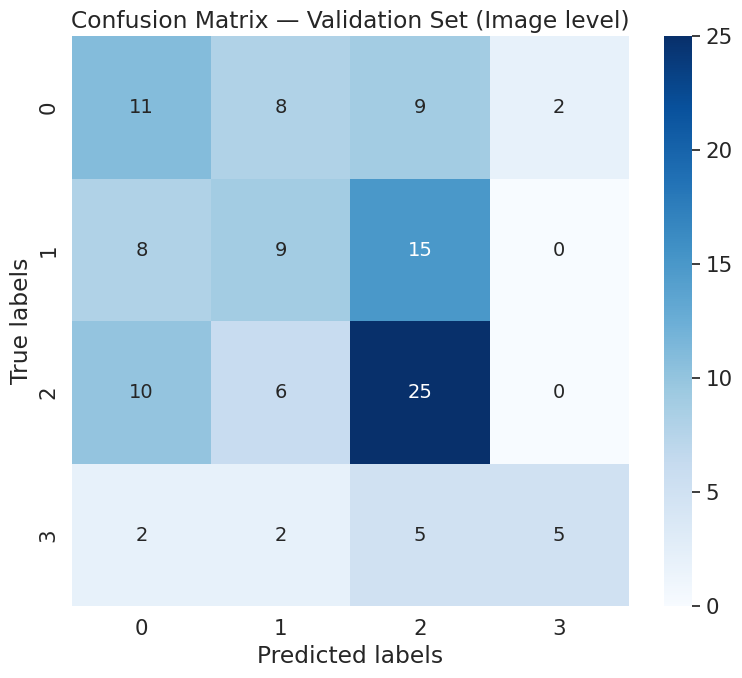

In [54]:
image_probs, image_targets = {}, {}
with torch.no_grad():  # Disable gradient computation for inference
    for img_ids, inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type = device.type,
                        enabled = (device.type == "cuda")):
            logits = tta_logits(final_model, inputs)

        # Convert logits to probabilities on CPU
        probs = torch.softmax(logits, dim = 1).cpu().numpy()
        targets_np = targets.cpu().numpy()

        # Accumulate for img_id
        for img_id, p, t in zip(img_ids, probs, targets_np):

            if img_id not in image_probs:
                image_probs[img_id] = []
                image_targets[img_id] = t

            image_probs[img_id].append(p)

val_img_preds, val_img_targets = [], []
for img_id in image_probs:
    patch_probs = np.stack(image_probs[img_id], axis=0)   # (n_patches, num_classes)
    patch_conf  = patch_probs.max(axis=1)                 # confidence per patch

    k = min(5, len(patch_conf))                           # try K=5
    topk_idx   = np.argsort(-patch_conf)[:k]
    topk_probs = patch_probs[topk_idx]

    mean_prob = topk_probs.mean(axis=0)
    pred   = np.argmax(mean_prob)
    target = image_targets[img_id]

    val_img_preds.append(pred)
    val_img_targets.append(target)


val_img_preds   = np.array(val_img_preds)
val_img_targets = np.array(val_img_targets)

# Calculate overall validation metrics
val_acc_img  = accuracy_score(val_img_targets, val_img_preds)
val_prec_img = precision_score(val_img_targets, val_img_preds, average = "weighted")
val_rec_img  = recall_score(val_img_targets, val_img_preds, average = "weighted")
val_f1_img   = f1_score(val_img_targets, val_img_preds, average = "weighted")
print("IMAGE LEVEL METRICS")
print(f"Accuracy over the validation set:  {val_acc_img:.4f}")
print(f"Precision over the validation set: {val_prec_img:.4f}")
print(f"Recall over the validation set:    {val_rec_img:.4f}")
print(f"F1 score over the validation set:  {val_f1_img:.4f}")

# Generate confusion matrix for detailed error analysis
cm_img = confusion_matrix(val_img_targets, val_img_preds)

# Create numeric labels for heatmap annotation
labels_img = np.array([f"{num}" for num in cm_img.flatten()]).reshape(cm_img.shape)

# Visualise confusion matrix
plt.figure(figsize = (8, 7))
sns.heatmap(cm_img, annot = labels_img, fmt = "", cmap = "Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix — Validation Set (Image level)")
plt.tight_layout()
plt.show()


## 🕹️ **Inference**

In [55]:
test_probs = []
test_img_ids = []

with torch.no_grad():  # Disable gradient computation for inference
    for _, inputs in test_loader:
        inputs = inputs.to(device)

        with torch.amp.autocast(device_type = device.type,
                        enabled = (device.type == "cuda")):
            logits = tta_logits(final_model, inputs)

        probs = F.softmax(logits, dim = 1).cpu().numpy()

        test_probs.append(probs)
        test_img_ids.extend(list(img_ids))

test_probs = np.concatenate(test_probs, axis = 0)

In [56]:
# Count how many patches per sample_index
patches_per_sample = X_c_test.groupby('sample_index').size().to_dict()

# Initialize vector of final label predictions
test_preds = []
pointer = 0

# Get label prediction for each sample
for sample_index in X_c_test['sample_index'].unique():
    n_patches = patches_per_sample[sample_index]

    sample_patch_probs = test_probs[pointer:pointer + n_patches]  # (n_patches, num_classes)
    pointer += n_patches

    patch_conf = sample_patch_probs.max(axis = 1)
    k = min(5, len(patch_conf))
    topk_idx   = np.argsort(-patch_conf)[:k]
    topk_probs = sample_patch_probs[topk_idx]

    mean_probs = topk_probs.mean(axis = 0)
    final_label = np.argmax(mean_probs)
    test_preds.append((sample_index, final_label))

In [57]:
sample_indexes, numeric_preds = zip(*test_preds)

# Convert numeric predictions to strings
labels = [int_to_label [p] for p in numeric_preds]

# Build DataFrame
results = pd.DataFrame({
    "sample_index": sample_indexes,
    "label": labels
})

In [58]:
from google.colab import files

# Save CSV locally in the Colab environment
results.to_csv("test_labels.csv", index=False)

# Download to your device
files.download("test_labels.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>